In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [4]:
import sectionate
print(f"Sectionate version: {sectionate.__version__}")

Sectionate version: 0.2.1


In [5]:
from Streamfunctions import *
from Streamfunctions_Sectionate import *

rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0

In [6]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        preprocess = get_transports, 
        engine="zarr")

ds_transport_snapshot = ds.isel(time = 0).compute()

NameError: name 'get_transports' is not defined

In [10]:
grid = CM4Xutils.ds_to_grid(ds_transport_snapshot, Zprefix = "sigma2")
moc_indices = generate_moc_grid_indices(grid, dlat=2.)

Processing latitudes:  99%|█████████▉| 88/89 [01:54<00:01,  1.29s/lat]/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/sectionate/section.py:517: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(np.clip((np.cos(a) - np.cos(b)*np.cos(c))/(np.sin(b)*np.sin(c)), -1., 1.))
Processing latitudes: 100%|██████████| 89/89 [01:55<00:00,  1.30s/lat]


In [13]:
%%time 
ds_transport = ds.compute()
grid = CM4Xutils.ds_to_grid(ds_transport, Zprefix = "sigma2")

CPU times: user 3.51 s, sys: 17.7 s, total: 21.2 s
Wall time: 25.8 s


In [14]:
%%time 
moc_time_result = moc_across_time(grid, moc_indices, time_dim = "time") * Sv_s_per_kg

/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src/Streamfunctions_Sectionate.py:89: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


CPU times: user 23.3 s, sys: 1.33 s, total: 24.6 s
Wall time: 24.7 s


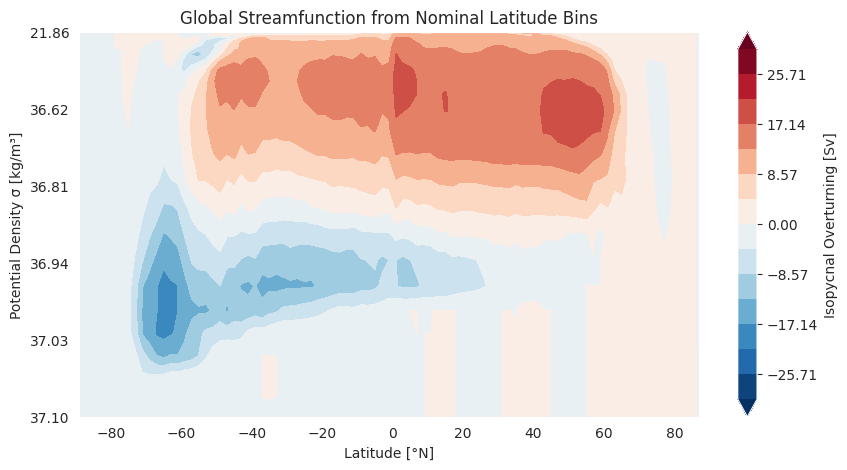

In [15]:
# If your variables have different names

psi_crop =  moc_time_result.mean("time").sel(sigma2_l = slice(20, 37.1))
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.linspace(-30, 30, 15)

plot_isopycnal_overturning(fig, ax, 
    psi_crop.isel(exp = 1).T,
    density_dim='sigma2_l',           # Your density dimension name
    lat_dim='lat',                  # Your latitude dimension name
    power = 50,
    levels = levels
)
ax.set_title("Global Streamfunction from Nominal Latitude Bins")
ax.invert_yaxis()

In [46]:
psi_yearly = psi.groupby("time.year").mean("time")
psi_yearly = psi_yearly.sel(sigma2_l = slice(36, 37.1))

In [47]:
locs = find_min_locations(psi_yearly.isel(exp = 1), fixed_dim = "year")
locs["geolat"] = 0 * locs["yq"]
locs["geolat"].values = psi_yearly["geolat"].sel(yq = locs["yq"]).values
nom_locs = locs["geolat"]

Text(0.5, 1.0, 'Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)')

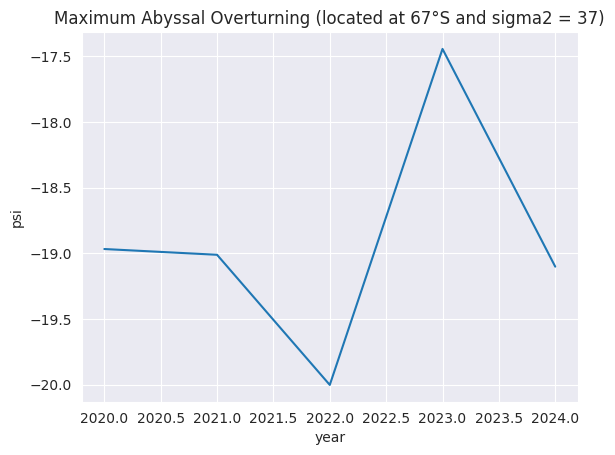

In [48]:
locs = find_min_locations(psi_yearly.isel(exp = 1).mean("year"))

fig, ax = plt.subplots()
(1e-6 * psi_yearly).isel(exp = 1).sel(locs).plot(ax = ax)
ax.set_title("Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)")

In [54]:
locs = find_min_locations(sectionate_psi.sel(sigma2_l = slice(36, 37.1)).isel(exp = 1), fixed_dim = "year")

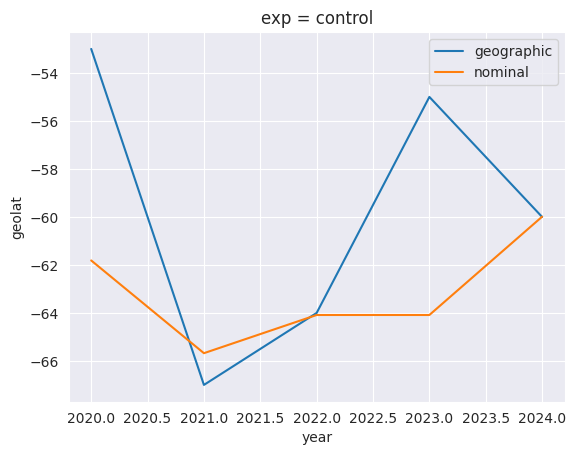

In [55]:
locs["lat"].plot(label = "geographic")
nom_locs.plot(label = "nominal")
plt.legend()